# End-to-End Data Cleaning Pipeline with Raha and Baran (Minimal and Sequential)
We build an end-to-end data cleaning pipeline with our configuration-free error detection and correction systems, Raha and Baran.

In [1]:
import pandas
import IPython.display
from pandas import DataFrame, Series
import pickle
import raha
import numpy as np
import matplotlib.pyplot as plt

## Error Detection with Raha

### 1. Instantiating the Detection Class
We first instantiate the `Detection` class.

In [2]:
app_1 = raha.Detection()

# How many tuples would you label?
app_1.LABELING_BUDGET = 20

# Would you like to see the logs?
app_1.VERBOSE = True

### 2. Instantiating the Dataset
We next load and instantiate the dataset object.

In [3]:
dataset_dictionary = {
        "name": "beers",
        "path": "datasets/beers/dirty.csv",
        "clean_path": "datasets/beers/clean.csv"
    }
d = app_1.initialize_dataset(dataset_dictionary)
d.dataframe.head()

,index,id,beer_name,style,ounces,abv,ibu,brewery_id,brewery_name,city,state
0,1,1436,Pub Beer,American Pale Lager,12.0 oz,0.05,N/A,408,10 Barrel Brewing Company,Bend,OR
1,2,2265,Devil's Cup,American Pale Ale (APA),12.0 oz.,0.066,N/A,177,18th Street Brewery,Gary,IN
2,3,2264,Rise of the Phoenix,American IPA,12.0 ounce,0.071,N/A,177,18th Street Brewery,Gary,IN
3,4,2263,Sinister,American Double / Imperial IPA,12.0 oz,0.09%,N/A,177,18th Street Brewery,Gary,IN
4,5,2262,Sex and Candy,American IPA,12.0 OZ.,0.075,N/A,177,18th Street Brewery,Gary,IN


### 3. Running Error Detection Strategies
Raha runs (all or the promising) error detection strategies on the dataset. This step could take a while because all the strategies should be run on the dataset. 

In [4]:
app_1.run_strategies(d)

511 strategy profiles are collected.


I just load strategies' results as they have already been run on the dataset!


### 4. Generating Features
Raha then generates a feature vector for each data cell based on the output of error detection strategies. 

In [5]:
app_1.generate_features(d)

44 Features are generated for column 0.
44 Features are generated for column 1.
133 Features are generated for column 2.
100 Features are generated for column 3.
63 Features are generated for column 4.
54 Features are generated for column 5.
54 Features are generated for column 6.
55 Features are generated for column 7.
103 Features are generated for column 8.
106 Features are generated for column 9.
75 Features are generated for column 10.


### 5. Building Clusters
Raha next builds a hierarchical clustering model for our clustering-based sampling approach.

In [6]:
app_1.build_clusters(d)

A hierarchical clustering model is built for column 0.
A hierarchical clustering model is built for column 1.
A hierarchical clustering model is built for column 2.
A hierarchical clustering model is built for column 3.
A hierarchical clustering model is built for column 4.
A hierarchical clustering model is built for column 5.
A hierarchical clustering model is built for column 6.
A hierarchical clustering model is built for column 7.
A hierarchical clustering model is built for column 8.
A hierarchical clustering model is built for column 9.
A hierarchical clustering model is built for column 10.


### 6. Interactive Tuple Sampling and Labeling
Raha then iteratively samples a tuple. We should label data cells of each sampled tuple.

In [7]:
while len(d.labeled_tuples) < app_1.LABELING_BUDGET:
    app_1.sample_tuple(d)
    if d.has_ground_truth:
        app_1.label_with_ground_truth(d)
    else:
        print("Label the dirty cells in the following sampled tuple.")
        sampled_tuple = pandas.DataFrame(data=[d.dataframe.iloc[d.sampled_tuple, :]], columns=d.dataframe.columns)
        IPython.display.display(sampled_tuple)
        for j in range(d.dataframe.shape[1]):
            cell = (d.sampled_tuple, j)
            value = d.dataframe.iloc[cell]
            correction = input("What is the correction for value '{}'? Type in the same value if it is not erronous.\n".format(value))
            user_label = 1 if value != correction else 0
            d.labeled_cells[cell] = [user_label, correction]
        d.labeled_tuples[d.sampled_tuple] = 1

Tuple 192 is sampled.
Tuple 192 is labeled.
Tuple 323 is sampled.
Tuple 323 is labeled.
Tuple 90 is sampled.
Tuple 90 is labeled.
Tuple 1121 is sampled.
Tuple 1121 is labeled.
Tuple 1185 is sampled.
Tuple 1185 is labeled.
Tuple 1666 is sampled.
Tuple 1666 is labeled.
Tuple 2251 is sampled.
Tuple 2251 is labeled.
Tuple 2395 is sampled.
Tuple 2395 is labeled.
Tuple 1039 is sampled.
Tuple 1039 is labeled.
Tuple 442 is sampled.
Tuple 442 is labeled.
Tuple 1955 is sampled.
Tuple 1955 is labeled.
Tuple 388 is sampled.
Tuple 388 is labeled.
Tuple 1969 is sampled.
Tuple 1969 is labeled.
Tuple 2394 is sampled.
Tuple 2394 is labeled.
Tuple 2391 is sampled.
Tuple 2391 is labeled.
Tuple 1579 is sampled.
Tuple 1579 is labeled.
Tuple 2260 is sampled.
Tuple 2260 is labeled.
Tuple 553 is sampled.
Tuple 553 is labeled.
Tuple 2221 is sampled.
Tuple 2221 is labeled.
Tuple 1000 is sampled.
Tuple 1000 is labeled.


### 7. Propagating User Labels
Raha then propagates each user label through its cluster.

In [8]:
app_1.propagate_labels(d)

The number of labeled data cells increased from 220 to 24548.


### 8. Predicting Labels of Data Cells
Raha then trains and applies one classifier per data column to predict the label of the rest of data cells.

In [9]:
app_1.predict_labels(d)

A classifier is trained and applied on column 0.
A classifier is trained and applied on column 1.
A classifier is trained and applied on column 2.
A classifier is trained and applied on column 3.
A classifier is trained and applied on column 4.
A classifier is trained and applied on column 5.
A classifier is trained and applied on column 6.
A classifier is trained and applied on column 7.
A classifier is trained and applied on column 8.
A classifier is trained and applied on column 9.
A classifier is trained and applied on column 10.


### 9. Storing Results
Raha can also store the error detection results.

In [10]:
app_1.store_results(d)

The results are stored in datasets/beers/raha-baran-results-beers/error-detection/detection.dataset.


### 10. Evaluating the Error Detection Task
We can finally evaluate our error detection task.

In [11]:
p, r, f = d.get_data_cleaning_evaluation(d.detected_cells)[:3]
print("Raha's performance on {}:\nPrecision = {:.2f}\nRecall = {:.2f}\nF1 = {:.2f}".format(d.name, p, r, f))

Raha's performance on beers:
Precision = 1.00
Recall = 1.00
F1 = 1.00


/home/adrian/source/MA/raha/raha/dataset.py:123: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if correction_dictionary[cell] == actual_errors[cell]:


# Error Correction with Baran

### 1. Instantiating the Correction Class
We first instantiate the `Correction` class.

In [12]:
app_2 = raha.Correction()

# How many tuples would you label?
app_2.LABELING_BUDGET = 20

# Would you like to see the logs?
app_2.VERBOSE = True

### 2. Initializing the Dataset Object
We next initialize the dataset object.

In [13]:
d = app_2.initialize_dataset(d)
d.dataframe.head()

,index,id,beer_name,style,ounces,abv,ibu,brewery_id,brewery_name,city,state
0,1,1436,Pub Beer,American Pale Lager,12.0 oz,0.05,N/A,408,10 Barrel Brewing Company,Bend,OR
1,2,2265,Devil's Cup,American Pale Ale (APA),12.0 oz.,0.066,N/A,177,18th Street Brewery,Gary,IN
2,3,2264,Rise of the Phoenix,American IPA,12.0 ounce,0.071,N/A,177,18th Street Brewery,Gary,IN
3,4,2263,Sinister,American Double / Imperial IPA,12.0 oz,0.09%,N/A,177,18th Street Brewery,Gary,IN
4,5,2262,Sex and Candy,American IPA,12.0 OZ.,0.075,N/A,177,18th Street Brewery,Gary,IN


### 3. Initializing the Error Corrector Models
Baran initializes the error corrector models.

In [14]:
app_2.initialize_models(d)

The error corrector models are initialized.


### 4. Interactive Tuple Sampling, Labeling, Model updating, Feature Generation, and Correction Prediction
Baran then iteratively samples a tuple. We should label data cells of each sampled tuple. It then udpates the models accordingly and generates a feature vector for each pair of a data error and a correction candidate. Finally, it trains and applies a classifier to each data column to predict the final correction of each data error. Since we already labeled tuples for Raha, we use the same labeled tuples and do not label new tuples here.

In [15]:
# while len(d.labeled_tuples) < app_2.LABELING_BUDGET:
#     app_2.sample_tuple(d)
#     if d.has_ground_truth:
#         app_2.label_with_ground_truth(d)
#     else:
#         print("Label the dirty cells in the following sampled tuple.")
#         sampled_tuple = pandas.DataFrame(data=[d.dataframe.iloc[d.sampled_tuple, :]], columns=d.dataframe.columns)
#         IPython.display.display(sampled_tuple)
#         for j in range(d.dataframe.shape[1]):
#             cell = (d.sampled_tuple, j)
#             value = d.dataframe.iloc[cell]
#             correction = input("What is the correction for value '{}'? Type in the same value if it is not erronous.\n".format(value))
#             user_label = 1 if value != correction else 0
#             d.labeled_cells[cell] = [user_label, correction]
#         d.labeled_tuples[d.sampled_tuple] = 1
#     app_2.update_models(d)
#     app_2.generate_features(d)
#     app_2.predict_corrections(d)

#labeled_tuples_list = list(d.labeled_tuples.keys())
#k = labeled_tuples_list[0]

#si = d.labeled_tuples[k]
#d.sampled_tuple = k
#app_2.update_models(d)
#app_2.generate_features(d)

for si in d.labeled_tuples:
    d.sampled_tuple = si
    app_2.update_models(d)
    app_2.generate_features(d)
    app_2.predict_corrections(d)

The error corrector models are updated with new labeled tuple 192.
215102 pairs of (a data error, a potential correction) are featurized.
Prediction Method in this step:
    Column 4: Train
    Column 5: Train
    Column 6: No train 0
    Column 9: Train
    Column 10: Train
Train sizes in this step:
    Column 4: 21
    Column 5: 207
    Column 6: 963
    Column 9: 1131
    Column 10: 153
Corrections identified in this step:
    Column 4: 2125 Mean correction confidence: 0.6292802510655409
    Column 5: 501 Mean correction confidence: 0.5273601408761199
    Column 6: 0.0 Mean correction confidence: nan
    Column 9: 119 Mean correction confidence: 0.9999999999999999
    Column 10: 143 Mean correction confidence: 0.9233932273223042
Corrections applied in this step:
    Column 4: 2125 Real changes: 0
    Column 5: 433 Real changes: 62
    Column 6: 0 Real changes: 0
    Column 9: 119 Real changes: 0
    Column 10: 122 Real changes: 22
63% (2753 / 4369) of data errors are corrected.
The 

In [16]:
#d.corrected_cells = {}

In [17]:
#app_2.predict_corrections(d)

### 5. Storing Results
Baran can also store the error correction results.

In [18]:
app_2.store_results(d)

The results are stored in datasets/beers/raha-baran-results-beers/error-correction/correction.dataset.


### 6. Evaluating the Error Correction Task
We can finally evaluate our error correction task.

In [19]:
p, r, f = d.get_data_cleaning_evaluation(d.corrected_cells)[-3:]
print("Baran's performance on {}:\nPrecision = {:.2f}\nRecall = {:.2f}\nF1 = {:.2f}".format(d.name, p, r, f))

Baran's performance on beers:
Precision = 0.94
Recall = 0.93
F1 = 0.93


### Further detection evaluation

In [ ]:
actual_errors = d.get_actual_errors_dictionary()
len(actual_errors)

In [21]:
#d = pickle.load(open("datasets/flights/raha-baran-results-flights/error-correction/correction.dataset", "rb"))

In [22]:
d.dataframe.shape[0] * d.dataframe.shape[1]

26510

In [111]:
import importlib
from raha import analysis_utilities

Histograms of the probabilities of the detection algorithm by (label, true label)


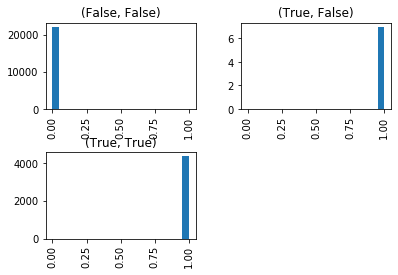

In [116]:
importlib.reload(analysis_utilities)

analysis_utilities.detection_evaluation(d, actual_errors)

### Correction feature analysis

In [ ]:
correction_features = []

for cell in d.corrected_cells:
    correction_features.append(list(cell) +
                               [d.dataframe.iloc[cell]] +
                               [d.corrected_cells[cell]] +
                               [actual_errors[cell] if cell in actual_errors else d.dataframe.iloc[cell]] +
                               list(d.pair_features[cell][d.corrected_cells[cell]]))

In [35]:
correction_features_df = DataFrame(correction_features,
                                   columns=["row",
                                            "column",
                                            "old_value",
                                            "new_value",
                                            "actual_value",
                                            *[f"feature_value_{i}" for i in range(8)],
                                            *[f"feature_vicinity_{i}" for i in range(d.dataframe.shape[1])],
                                            "feature_domain"])

In [36]:
correction_features_df.iloc[:,5:].mean().sort_values()

feature_value_4        0.000000
feature_value_5        0.000000
feature_vicinity_4     0.000000
feature_value_2        0.002169
feature_value_3        0.002169
feature_vicinity_1     0.008829
feature_vicinity_0     0.008829
feature_vicinity_2     0.027138
feature_vicinity_6     0.051442
feature_vicinity_9     0.059025
feature_vicinity_7     0.111781
feature_vicinity_8     0.114336
feature_vicinity_5     0.131783
feature_vicinity_3     0.185038
feature_vicinity_10    0.185315
feature_domain         0.323399
feature_value_7        0.570616
feature_value_0        0.676115
feature_value_6        0.678284
feature_value_1        0.890567
dtype: float64

In [37]:
correction_features_df.iloc[:,[1] + list(range(5,correction_features_df.shape[1]))].groupby("column").mean()

,feature_value_0,feature_value_1,feature_value_2,feature_value_3,feature_value_4,feature_value_5,feature_value_6,feature_value_7,feature_vicinity_0,feature_vicinity_1,feature_vicinity_2,feature_vicinity_3,feature_vicinity_4,feature_vicinity_5,feature_vicinity_6,feature_vicinity_7,feature_vicinity_8,feature_vicinity_9,feature_vicinity_10,feature_domain
column,,,,,,,,,,,,,,,,,,,,
4,0.777593,0.945228,0.000000,0.000000,0.0,0.0,0.777593,0.575768,0.008299,0.008299,0.008714,0.288313,0.0,0.203320,0.074689,0.054772,0.060166,0.071784,0.312725,0.562490
5,0.043818,0.851330,0.000000,0.000000,0.0,0.0,0.043818,0.029734,0.004695,0.004695,0.083881,0.074989,0.0,0.000000,0.051269,0.098513,0.099977,0.071422,0.049827,0.036176
6,1.000000,1.000000,0.000000,0.000000,0.0,0.0,1.000000,1.000000,0.008955,0.008955,0.008955,0.042727,0.0,0.067173,0.000000,0.072790,0.072790,0.035227,0.012028,0.006365
9,0.024000,0.048000,0.000000,0.000000,0.0,0.0,0.024000,0.280000,0.024000,0.024000,0.132800,0.021662,0.0,0.022872,0.019034,0.736000,0.712520,0.000000,0.000000,0.006596
10,0.000000,0.000000,0.074667,0.074667,0.0,0.0,0.074667,0.074667,0.024000,0.024000,0.132800,0.064030,0.0,0.054594,0.050130,0.968000,0.968000,0.000000,0.000000,0.047773


In [38]:
correction_features_df["wrong_correction"] = (correction_features_df["old_value"] == correction_features_df["actual_value"]) & (correction_features_df["old_value"] != correction_features_df["new_value"])

In [39]:
correction_features_df["wrong_correction"].sum() / correction_features_df.shape[0]

0.0

In [40]:
distinct_features = []

for column_index in range(d.dataframe.shape[1]):
    unique_rows = np.unique(d.column_features[column_index], axis=0)
    distinct_features.append(unique_rows.shape[0])

distinct_features

[1162, 1171, 2311, 282, 160, 358, 237, 693, 745, 619, 149]

In [41]:
cluster_features = []

for cluster_i in range(1,21):
    cluster_features.append(d.column_features[3][
        [key[0] for key in d.clusters_k_j_c_ce[21][3][cluster_i].keys()]])

In [93]:
cluster_feature_means = np.array([cluster.mean(axis=0) for cluster in cluster_features])
cluster_feature_means

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 1.        , ..., 0.        , 0.        ,
        1.        ],
       [0.99363057, 0.8089172 , 0.23566879, ..., 0.        , 0.        ,
        0.98726115],
       ...,
       [1.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [94]:
Series([len(cluster) for cluster in d.clusters_k_j_c_ce[21][3].values()]).value_counts().sort_index()

1       6
2       4
3       1
5       1
7       1
26      1
30      1
53      1
59      1
69      1
86      1
157     1
1901    1
dtype: int64

### Correction prediction analysis

In [ ]:
df = d.correction_prediction_dfs[0][5]

In [45]:
df["prediction"].sum()

501

In [46]:
df["prediction"].groupby(df["cell"]).sum().sort_values()

cell
(3, 5)       0
(1403, 5)    0
(1402, 5)    0
(1397, 5)    0
(1368, 5)    0
(1364, 5)    0
(1359, 5)    0
(1334, 5)    0
(1333, 5)    0
(1321, 5)    0
(1307, 5)    0
(1306, 5)    0
(1421, 5)    0
(1295, 5)    0
(1288, 5)    0
(1283, 5)    0
(1273, 5)    0
(1238, 5)    0
(1235, 5)    0
(1232, 5)    0
(1213, 5)    0
(1203, 5)    0
(1182, 5)    0
(1181, 5)    0
(1177, 5)    0
(1293, 5)    0
(1157, 5)    0
(1423, 5)    0
(1430, 5)    0
(1634, 5)    0
            ..
(1988, 5)    2
(1165, 5)    2
(179, 5)     2
(2124, 5)    2
(1162, 5)    2
(1951, 5)    3
(1614, 5)    3
(1603, 5)    3
(78, 5)      3
(2141, 5)    3
(2197, 5)    3
(1131, 5)    3
(1933, 5)    3
(1223, 5)    3
(1254, 5)    3
(501, 5)     3
(788, 5)     3
(1695, 5)    4
(1952, 5)    4
(1474, 5)    4
(1928, 5)    4
(1925, 5)    4
(1226, 5)    4
(669, 5)     4
(681, 5)     4
(1947, 5)    4
(1233, 5)    4
(667, 5)     5
(685, 5)     5
(331, 5)     6
Name: prediction, Length: 690, dtype: int64

In [47]:
#df = df[df["prediction"] == 1]

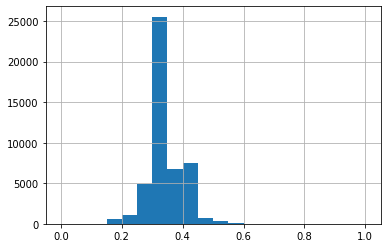

In [48]:
df["probability"].hist(bins=np.linspace(0.0, 1.0, 21))

In [49]:
aggregated = df[df["prediction"] == 1].groupby("cell").agg({"prediction": "sum",
                                     "cell": "first",
                                     "probability": list,
                                     "correction": list})
aggregated

,prediction,cell,probability,correction
cell,,,,
"(12, 5)",1,"(12, 5)",[0.5129718302458491],[0.067]
"(26, 5)",1,"(26, 5)",[0.5117321209240264],[0.067]
"(35, 5)",1,"(35, 5)",[0.5246889485427785],[0.067]
"(44, 5)",2,"(44, 5)","[0.5596671708080119, 0.5026945983566269]","[0.05, 0.053]"
"(46, 5)",2,"(46, 5)","[0.5129718302458491, 0.5596671708080119]","[0.067, 0.05]"
"(70, 5)",1,"(70, 5)",[0.5468403303422108],[0.05]
"(78, 5)",3,"(78, 5)","[0.5129718302458491, 0.5184749112477279, 0.502...","[0.067, 0.05, 0.053]"
"(79, 5)",1,"(79, 5)",[0.5468403303422108],[0.05]
"(96, 5)",1,"(96, 5)",[0.5246889485427785],[0.067]


In [50]:
# Compare correction and actual
cell = (59,5)
print(d.corrected_cells[cell])
print(actual_errors[cell])

KeyError: (59, 5)

In [51]:
correction_confidence_df = analysis_utilities.get_correction_confidence_df(d, actual_errors)

,cell,confidence,detection_correct,correct
0,"(90, 4)",1.000000,True,True
1,"(192, 4)",1.000000,True,True
2,"(323, 4)",1.000000,True,True
3,"(388, 4)",1.000000,True,True
4,"(442, 4)",1.000000,True,True
5,"(553, 4)",1.000000,True,True
6,"(1000, 4)",1.000000,True,True
7,"(1039, 4)",1.000000,True,True
8,"(1121, 4)",1.000000,True,True
9,"(1185, 4)",1.000000,True,True


Distribution of confidences for wrong (False) and correct (True) corrections:


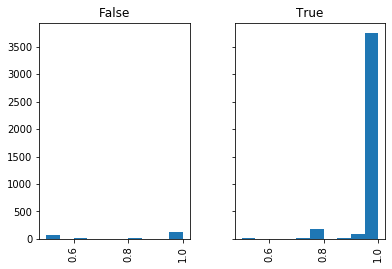

In [129]:
analysis_utilities.correction_confidence_distributions(correction_confidence_df)

Empirical probability of a correction being wrong given its confidence:


/home/adrian/anaconda3/envs/raha/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


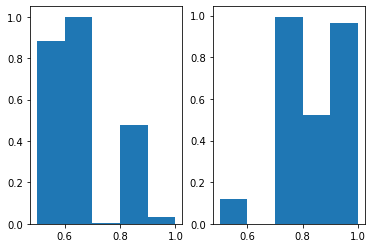

In [135]:
importlib.reload(analysis_utilities)

f = analysis_utilities.correction_correctness_by_confidence(correction_confidence_df)
f.show()

### Analyze steps

In [53]:
# Prediction of step 0 for column 5
d.correction_prediction_dfs[0][5][d.correction_prediction_dfs[0][5]["prediction"] == 1]

,cell,correction,prediction,probability
143,"(12, 5)",0.067,1,0.512972
307,"(26, 5)",0.067,1,0.511732
564,"(35, 5)",0.067,1,0.524689
690,"(44, 5)",0.05,1,0.559667
704,"(44, 5)",0.053,1,0.502695
771,"(46, 5)",0.067,1,0.512972
774,"(46, 5)",0.05,1,0.559667
1045,"(70, 5)",0.05,1,0.546840
1109,"(78, 5)",0.067,1,0.512972
1114,"(78, 5)",0.05,1,0.518475


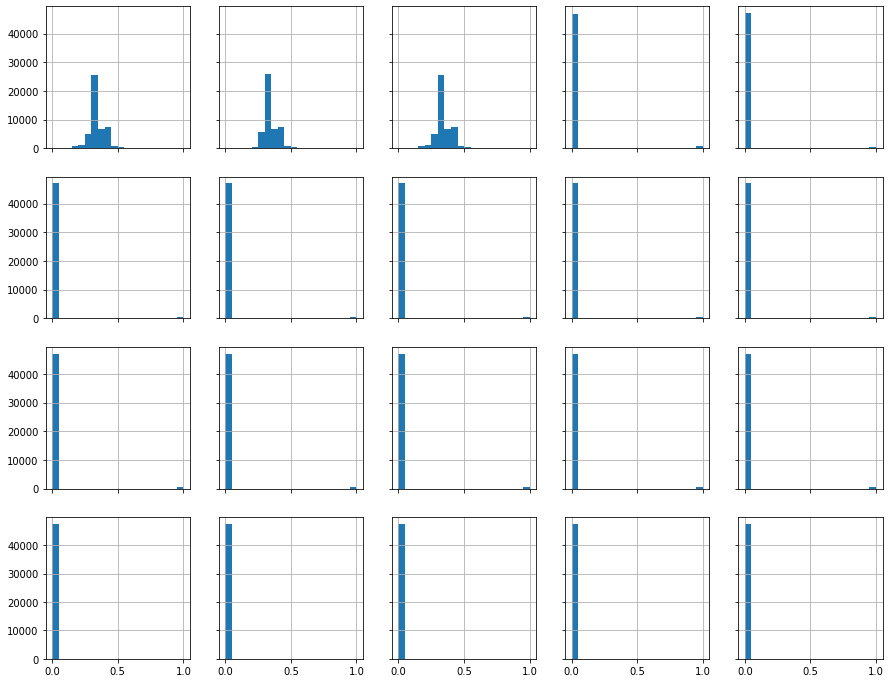

In [102]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 5, sharex="all", sharey="row", figsize=(15,12))

for row in range(4):
    for column in range(5):
        df = d.correction_prediction_dfs[row * 5 + column][5]
        df["probability"].hist(bins=np.linspace(0.0, 1.0, 21), ax=axs[row][column])